# A/B Testing Topics

**Notebook Contents:**

* Power Analysis & Sample Size Estimation
* Sample Size Estimation: Ratio Metrics
* Relative (%) Change Confidence Intervals
* Statistical Significance Testing for Ratio Metrics (Delta Method)
* A/B/n Testing (Multiple Variants)

In [89]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import random
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import scikit_posthocs as sp

# Power Analysis

`Effect size = the minimum detectable effect (MDE) you care about detecting, expressed in standardized units`

![Effect_Size.png](images/Effect_Size.png)

## Sample Size Estimation

In [22]:
# solve power for 2 sample z-test of proportions
    # You can solve for any parameter by leaving it as None and providing the others
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize

# Given: baseline and expected conversion rates
prop_control = 0.08
minimum_detectable_effect = 0.10  # 10% relative lift
prop_treatment = prop_control * (1 + minimum_detectable_effect)  # 8.8%

# Calculate effect size (h) for proportions
effect_size = proportion_effectsize(prop_treatment, prop_control)

alpha = 0.05
power = 0.80

# Calculate required sample size per group
n_per_group = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1.0, # ratio = n_treatment / n_control
    alternative='two-sided',
    nobs1=None
)

print("="*10 + " Power and Sample Size Estimation " + "="*10)
print(f"Baseline rate: {prop_control:.3}")
print(f"Treatment rate: {prop_treatment:.3}")
print(f"Absolute difference: {(prop_treatment - prop_control):.3}")
print(f"Relative difference: {(minimum_detectable_effect * 100)}%")
print(f"Effect size (h): {effect_size:.4f}")
print(f"Required sample size per group: {np.ceil(n_per_group):.0f}")
print(f"Total sample size needed: {np.ceil(n_per_group * 2):.0f}")

========== Power and Sample Size Estimation ==========
Baseline rate: 0.08
Treatment rate: 0.088
Absolute difference: 0.008
Relative difference: 10.0%
Effect size (h): 0.0288
Required sample size per group: 18863
Total sample size needed: 37725


---
## Sample Size Estimation: Ratio Metrics

In [23]:
from statsmodels.stats.power import zt_ind_solve_power
import numpy as np

# Historical data per user
mean_clicks_per_user = 2.5
mean_impressions_per_user = 50
baseline_ctr = mean_clicks_per_user / mean_impressions_per_user  # 0.05

# Variance using Delta method
var_clicks = 3.2  # Variance of clicks per user (from historical data)
var_impressions = 625  # Variance of impressions per user
cov_clicks_impressions = 40  # Covariance between clicks and impressions

# Delta method variance formula for ratio
var_ratio = (1 / mean_impressions_per_user**2) * (
    var_clicks 
    - 2 * baseline_ctr * cov_clicks_impressions 
    + baseline_ctr**2 * var_impressions
)

std_ratio = np.sqrt(var_ratio)

# Expected treatment CTR
minimum_detectable_effect = 0.10  # 10% relative lift
treatment_ctr = baseline_ctr * (1 + minimum_detectable_effect)

# Effect size (difference divided by pooled std)
effect_size = (treatment_ctr - baseline_ctr) / std_ratio

# Sample size (number of USERS)
n_users = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.80,
    alternative='two-sided'
)

# Prepare formatted output
abs_diff = treatment_ctr - baseline_ctr
rel_diff = minimum_detectable_effect * 100
total_sample = np.ceil(n_users) * 2

print("\n========== Power and Sample Size Estimation ==========")
print(f"Baseline rate: {baseline_ctr:.3f}")
print(f"Treatment rate: {treatment_ctr:.3f}")
print(f"Absolute difference: {abs_diff:.3f}")
print(f"Relative difference: {rel_diff:.1f}%")
print(f"Effect size (h): {effect_size:.4f}")
print(f"Required sample size per group: {np.ceil(n_users):,.0f}")
print(f"Total sample size needed: {total_sample:,.0f}")


========== Power and Sample Size Estimation ==========
Baseline rate: 0.050
Treatment rate: 0.055
Absolute difference: 0.005
Relative difference: 10.0%
Effect size (h): 0.2863
Required sample size per group: 192
Total sample size needed: 384


---
## Visualizaing Power Curves

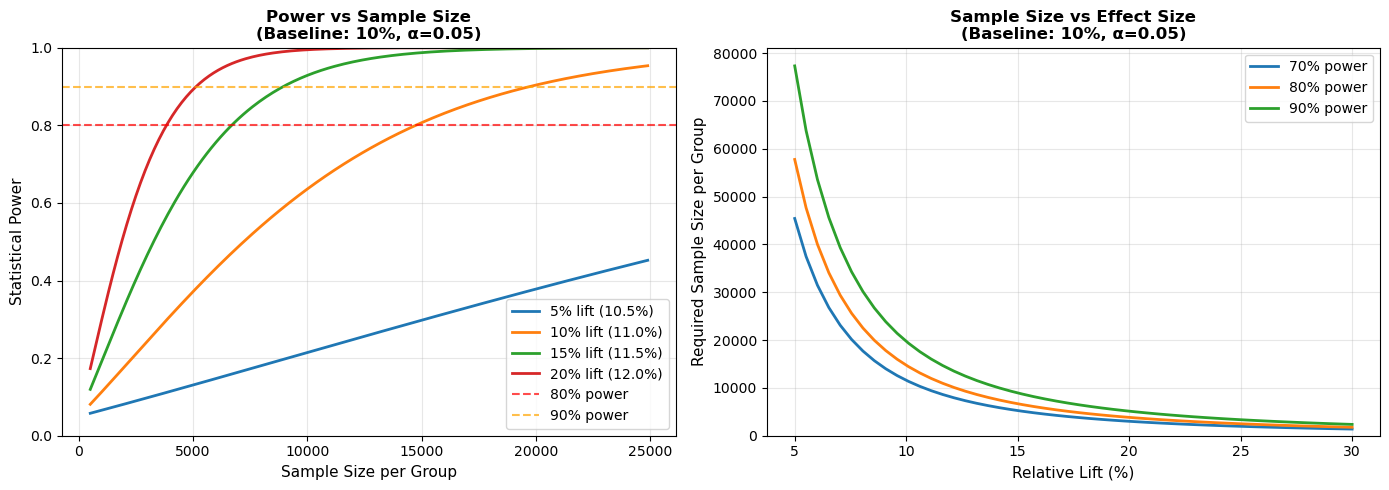

Example: Detecting 10% relative lift (10% → 11%)
Power = 80%: n = 14,745 per group (29,489 total)
Power = 90%: n = 19,739 per group (39,477 total)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize

# Set up parameters
baseline_rate = 0.10
alpha = 0.05
sample_sizes = np.arange(500, 25000, 100)

# Different effect sizes to compare (relative lifts)
relative_lifts = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20%

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Power vs Sample Size for different effect sizes
ax1 = axes[0]
for lift in relative_lifts:
    treatment_rate = baseline_rate * (1 + lift)
    effect_size = proportion_effectsize(baseline_rate, treatment_rate)
    
    powers = []
    for n in sample_sizes:
        power = zt_ind_solve_power(
            effect_size=effect_size,
            nobs1=n,
            alpha=alpha,
            ratio=1.0,
            alternative='two-sided'
        )
        powers.append(power)
    
    ax1.plot(sample_sizes, powers, label=f'{lift*100:.0f}% lift ({treatment_rate:.1%})', linewidth=2)

ax1.axhline(y=0.80, color='red', linestyle='--', label='80% power', alpha=0.7)
ax1.axhline(y=0.90, color='orange', linestyle='--', label='90% power', alpha=0.7)
ax1.set_xlabel('Sample Size per Group', fontsize=11)
ax1.set_ylabel('Statistical Power', fontsize=11)
ax1.set_title('Power vs Sample Size\n(Baseline: 10%, α=0.05)', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Sample Size vs Effect Size for different power levels
ax2 = axes[1]
effect_sizes_range = np.linspace(0.05, 0.30, 50)  # 5% to 30% relative lift
power_levels = [0.70, 0.80, 0.90]

for power_level in power_levels:
    sample_sizes_needed = []
    for lift in effect_sizes_range:
        treatment_rate = baseline_rate * (1 + lift)
        effect_size = proportion_effectsize(baseline_rate, treatment_rate)
        
        n = zt_ind_solve_power(
            effect_size=effect_size,
            alpha=alpha,
            power=power_level,
            ratio=1.0,
            alternative='two-sided'
        )
        sample_sizes_needed.append(n)
    
    ax2.plot(effect_sizes_range * 100, sample_sizes_needed, 
             label=f'{power_level*100:.0f}% power', linewidth=2)

ax2.set_xlabel('Relative Lift (%)', fontsize=11)
ax2.set_ylabel('Required Sample Size per Group', fontsize=11)
ax2.set_title('Sample Size vs Effect Size\n(Baseline: 10%, α=0.05)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print example calculations
print("="*60)
print("Example: Detecting 10% relative lift (10% → 11%)")
print("="*60)
lift = 0.10
treatment_rate = baseline_rate * (1 + lift)
effect_size = proportion_effectsize(baseline_rate, treatment_rate)

for power_level in [0.80, 0.90]:
    n = zt_ind_solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power_level,
        ratio=1.0,
        alternative='two-sided'
    )
    print(f"Power = {power_level:.0%}: n = {np.ceil(n):,.0f} per group ({np.ceil(n*2):,.0f} total)")

---
# Relative (%) Change Confidence Intervals

* the statistical model corresponding to testing for absolute difference is different than the statistical model for testing relative differences
* It increases the variance of estimates: `the greater the actual difference between control proportion and treatment proprtion, the more it increases the variance of the relative difference` compared to the abosulte difference
* greater variance => higher p-values & wider confidence intervals for equivalent relative difference

---

In [25]:
customer_journey = pd.read_csv('data/customer_journey.csv')
customer_journey.head()

,SessionID,UserID,Timestamp,PageType,DeviceType,Country,ReferralSource,TimeOnPage_seconds,ItemsInCart,Purchased
0,session_0,user_2223,2025-01-20 22:53:34,home,Desktop,India,Social Media,55,0,0
1,session_1,user_2192,2025-02-26 12:57:10,home,Tablet,Germany,Email,99,0,0
2,session_1,user_2192,2025-02-26 12:59:11,product_page,Tablet,Germany,Email,121,0,0
3,session_2,user_1708,2025-06-24 15:40:46,home,Mobile,India,Google,160,0,0
4,session_3,user_2976,2025-06-11 07:21:02,home,Tablet,UK,Google,113,0,0


In [26]:
df_conversion = customer_journey.groupby('UserID').agg({
    'SessionID': 'count',
    'Purchased': 'max'
}).reset_index()

df_conversion.head()

,UserID,SessionID,Purchased
0,user_1001,7,1
1,user_1002,7,1
2,user_1004,1,0
3,user_1005,10,1
4,user_1006,7,0


In [27]:
# Define groups
groups = ['group1', 'group2', 'group3', 'control']

# Randomly assign each user to a group
np.random.seed(42)
df_conversion['variant'] = np.random.choice(groups, size=len(df_conversion), replace=True)

df_conversion['variant'] = df_conversion['variant'].map({
    "control": "group_3",
    "group3": "control",
    "group2": "group_2",
    "group1": "group_1"
})

In [28]:
df_conversion_variant = df_conversion.groupby(['variant']).agg({
    "UserID": "count",
    "Purchased": "sum",
}).reset_index()

df_conversion_variant['Conversion'] = df_conversion_variant['Purchased'].divide(df_conversion_variant['UserID'])
df_conversion_variant

,variant,UserID,Purchased,Conversion
0,control,460,181,0.393478
1,group_1,486,202,0.415638
2,group_2,459,197,0.429194
3,group_3,467,212,0.453961


In [29]:
p_control = df_conversion_variant.loc[df_conversion_variant['variant'] == 'control', 'Conversion'].iloc[0]
p_group3 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_3', 'Conversion'].iloc[0]

n_control = df_conversion_variant.loc[df_conversion_variant['variant'] == 'control', 'UserID'].iloc[0]
n_group3 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_3', 'UserID'].iloc[0]

print(f"Control:\t p̂ = {p_control:.4f}\t n = {n_control}")
print(f"Group 3:\t p̂ = {p_group3:.4f}\t n = {n_group3}")

Control:	 p̂ = 0.3935	 n = 460
Group 3:	 p̂ = 0.4540	 n = 467


### Naive Relative Change Confidence Interval (Wrong Way)

* calculates % chg onfidence interval via abosulte difference statistical model

In [32]:
# Manual 2 sample proportions z-test

# --- 1. Compute pooled (weighted) proportion ---
# Combines success rates across both samples to estimate shared population proportion under H₀
p_weighted = ((p_control * n_control) + (p_group3 * n_group3)) / (n_control + n_group3)

# --- 2. Compute standard error (SE) ---
# Formula for SE of difference between two proportions
standard_error = np.sqrt(
    (p_weighted * (1 - p_weighted)) / n_control +
    (p_weighted * (1 - p_weighted)) / n_group3
)

# --- 3. Compute z-score ---
# Measures how many SEs the observed difference is away from 0
z_score = (p_group3 - p_control) / standard_error

# --- 4. Compute one-tailed p-value ---
alpha = 0.05
p_value = 1 - norm.cdf(abs(z_score))
crit = norm.ppf(1 - alpha)
SE_ci = np.sqrt(
    (p_control * (1 - p_control)) / n_control +
    (p_group3 * (1 - p_group3)) / n_group3
)

ci_lower = (p_group3 - p_control) - crit * SE_ci
ci_upper = (p_group3 - p_control) + crit * SE_ci
# ci_upper = float('inf')  # Upper bound is infinity for one-tailed test

# --- 5. Print summary statistics ---
print("=== Two-Sample Proportion Z-Test: One-sided (Superiority) ===")
print(f"Group 3 proportion: {p_group3:.4f}")
print(f"Control proportion: {p_control:.4f}")
print(f"Pooled (weighted) proportion: {p_weighted:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"Z-Score: {z_score:.3f}")
print(f"One-tailed p-value: {p_value:.4f}")
print(f"Critical Value: {crit:.4f}")
print(f"SE CI: {SE_ci:.4f}")
print(f"Confidence Interval - Absolute Difference - Upper: {ci_lower:.3f}, {float('inf'):.3f}")
print(f"Confidence Interval - Absolute Difference - Lower: {float('inf'):.3f}, {ci_upper:.3f}")
print(f"Confidence Interval - Relative (Naive) - Upper: {(ci_lower/p_control) * 100:.3f}%, {float('inf'):.3f}")
print(f"Confidence Interval - Relative (Naive) - Lower: {float('inf'):.3f}, {(ci_upper/p_control) * 100:.3f}%")

# --- 6. Decision rule ---
alpha = 0.05
if p_value < alpha:
    print(f"Reject H₀ ✅ (p < {alpha}) → Significant difference between Group 3 and Control")
else:
    print(f"Fail to Reject H₀ ❌ (p ≥ {alpha}) → No significant difference between Group 3 and Control")

=== Two-Sample Proportion Z-Test: One-sided (Superiority) ===
Group 3 proportion: 0.4540
Control proportion: 0.3935
Pooled (weighted) proportion: 0.4239
Standard Error: 0.0325
Z-Score: 1.863
One-tailed p-value: 0.0312
Critical Value: 1.6449
SE CI: 0.0324
Confidence Interval - Absolute Difference - Upper: 0.007, inf
Confidence Interval - Absolute Difference - Lower: inf, 0.114
Confidence Interval - Relative (Naive) - Upper: 1.828%, inf
Confidence Interval - Relative (Naive) - Lower: inf, 28.915%
Reject H₀ ✅ (p < 0.05) → Significant difference between Group 3 and Control


### Recalculated Relative Change Confidence Interval (Right Way)

* relative difference (treatment - control) / control requires different confidence interval calculation
* Reference: Statistical Methods Online A/B Testing Ch.9 page 154
    * CV_a = coefficient of variation control, relative standard deviation => std_a / prop_a
    * CV_b = coefficient of variation treatment, relative standard deviation => std_b / prop_b
    * Z = critical value

In [33]:
std_control = np.sqrt(p_control * (1 - p_control) / n_control)
std_group3 = np.sqrt(p_group3 * (1 - p_group3) / n_group3)
rel_diff = (p_group3 - p_control) / p_control

alpha = 0.05
CV_control = std_control/ p_control
CV_group3 = std_group3 / p_group3
Z = norm.ppf(1 - alpha)

# relative (pct) difference confidence interval calculation
numerator = np.sqrt(CV_control**2 + CV_group3**2 - Z**2 * CV_control**2 * CV_group3**2)
denominator = np.sqrt(1 - Z * CV_control**2)

CI_pct_lower = (rel_diff + 1) * ((1 - Z * numerator) / denominator) - 1
CI_pct_upper = (rel_diff + 1) * ((1 + Z * numerator) / denominator) - 1

print(f"Control - SD: {std_control:.3f}, CV: {CV_control:.3f}")
print(f"Group 3 - SD: {std_group3:.3f}, CV: {CV_group3:.3f}")
print(f"Relative Difference: {rel_diff :.4f}")
print(f"Critical Value: {Z:.3f}")
print("="*10 + ' Confidence Interval Comparison ' + "="*10)
print(f"Confidence Interval - Relative Chg (Naive) - Upper: {(ci_lower/p_control) * 100:.3f}%, {float('inf'):.3f}")
print(f"Confidence Interval - Relative Chg (Naive) - Lower: {float('inf'):.3f}, {(ci_upper/p_control) * 100:.3f}%")
print(f"Confidence Interval - Relative Chg (Proper) - Upper: {CI_pct_lower * 100:.3f}%, {float('inf'):.3f}")
print(f"Confidence Interval - Relative Chg (Proper) - Lower: {float('inf'):.3f}, {CI_pct_upper * 100:.3f}%")

Control - SD: 0.023, CV: 0.058
Group 3 - SD: 0.023, CV: 0.051
Relative Difference: 0.1537
Critical Value: 1.645
========== Confidence Interval Comparison ==========
Confidence Interval - Relative Chg (Naive) - Upper: 1.828%, inf
Confidence Interval - Relative Chg (Naive) - Lower: inf, 28.915%
Confidence Interval - Relative Chg (Proper) - Upper: 1.070%, inf
Confidence Interval - Relative Chg (Proper) - Lower: inf, 30.311%


---
# Statistical Significance Testing for Ratio Metrics (Delta Method)

**Overview:**

* Mean and variance formula only applied to i.i.d (independent and identically distributed) random variables simple variance formulas because they're ratios of two random variables
* Business metrics can be defined as ratios, for example, CTR which is defined as Clicks/Views
* Clicks and views are random variables, when we combined them as a single metric CTR they will have joint distribution
* Also, one user is possibly generated multiple views so that the views are not independent of each other
* Delta method extends the normal approximations of the central limit theorem. Delta method approximates asymptotically normal random variables by applying the Taylor series on the function of random variables
---

In [39]:
df_checkout = pd.read_csv('data/checkout.csv')
df_checkout.drop('Unnamed: 0', axis=1, inplace=True)

In [40]:
df_checkout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9000 non-null   int64  
 1   checkout_page  9000 non-null   object 
 2   order_value    7605 non-null   float64
 3   purchased      9000 non-null   float64
 4   gender         9000 non-null   object 
 5   browser        9000 non-null   object 
 6   time_on_page   9000 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 492.3+ KB


In [41]:
df_checkout.head()

,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,877621,A,29.410131,1.0,F,chrome,66.168628
1,876599,A,NaN,0.0,M,firefox,49.801887
2,905407,A,27.446845,1.0,M,chrome,56.744856
3,883562,A,30.602233,1.0,M,safari,71.890718
4,840542,A,29.668895,1.0,F,safari,67.410696


In [42]:
# AOV is only purchasing users
df_checkout.groupby('checkout_page')[['order_value', 'purchased']].agg(
    {'sum', 'count', 'mean'})

order_value                     purchased              
                     mean count           sum      mean count     sum
checkout_page                                                        
A               24.956437  2461  61417.791564  0.820333  3000  2461.0
B               29.876202  2541  75915.430125  0.847000  3000  2541.0
C               34.917589  2603  90890.484142  0.867667  3000  2603.0

In [43]:
# AOV denomator is all users, purchased or not
df_checkout.groupby('checkout_page')['order_value'].sum()/ \
df_checkout.groupby('checkout_page')['purchased'].count()

checkout_page
A    20.472597
B    25.305143
C    30.296828
dtype: float64

## Delta Method Example: Statistical Significance

* Example: A practical example of applying the Delta method in Python to analyze A/B test results, specifically looking at the difference in `average order value per page view` between two variants.

In [44]:
# z-test delta method function via Data Camp A/B Testing course
def var_delta(x,y): 
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    x_var = np.var(x,ddof=1)
    y_var = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]    
    var_ratio = (x_var/y_bar**2 + y_var*(x_bar**2/y_bar**4) - 2*cov_xy*(x_bar/y_bar**3))/len(x)
    return var_ratio

def ztest_delta(x_control,y_control,x_treatment,y_treatment, alpha = 0.05):
    mean_control = x_control.sum()/y_control.sum()
    mean_treatment = x_treatment.sum()/y_treatment.sum()
    var_control = var_delta(x_control, y_control)
    var_treatment = var_delta(x_treatment, y_treatment)
    diff = mean_treatment - mean_control
    var = var_control + var_treatment
    # Calculate the two-tailed critical value
    cv = stats.norm.ppf(1-alpha/2)
    # Calculate the z_stat
    z_stat = diff/np.sqrt(var)
    # Calculate the p-value
    p_val = stats.norm.sf(abs(z_stat)) * 2.0
    # Calculate confidence intervals of the difference
    stde = cv*np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    result = {'mean_control':mean_control,
              'mean_treatment':mean_treatment,
              'difference':round(diff, 3),
              'diff_CI':"["+str(round(lower,3))+", "+str(round(upper,3))+"]",
              'p-value':p_val}
    return result

In [47]:
# Create DataFrames for per user metrics for variants A and C
A_per_user = pd.DataFrame({'order_value':df_checkout[df_checkout['checkout_page']=='A'].groupby('user_id')['order_value'].sum()
                            ,'page_view':df_checkout[df_checkout['checkout_page']=='A'].groupby('user_id')['user_id'].count()})

C_per_user = pd.DataFrame({'order_value':df_checkout[df_checkout['checkout_page']=='C'].groupby('user_id')['order_value'].sum()
                           ,'page_view':df_checkout[df_checkout['checkout_page']=='C'].groupby('user_id')['user_id'].count()})

# Assign the control and treatment ratio columns 
x_control = A_per_user['order_value']
y_control = A_per_user['page_view']
x_treatment = C_per_user['order_value']
y_treatment = C_per_user['page_view']

# Run a z-test for ratio metrics
ztest_delta(x_control, y_control, x_treatment, y_treatment, alpha=0.05)

{'mean_control': np.float64(20.472597188012),
 'mean_treatment': np.float64(30.29682804716834),
 'difference': np.float64(9.824),
 'diff_CI': '[9.25, 10.398]',
 'p-value': np.float64(1.5695484218904427e-246)}

---
# A/B/n Testing (Multiple Variants)

By Metric Type: Means, Proportions, Ratios
* Statistical Significance
* Post-hoc Analysis
* Sample Size Calculation
* Confidence Interval

---
## Multivariate Testing (Comparing Means)

* Statistical Significance: [Dunnett's Test](#Dunnett's-Correction-for-A/B/n-Test)
* Post-hoc Analysis (exploratory): [Pairwise Tests with padjust](#Post-Hoc-Analysis-(Pairwise-t-tests))
* Sample Size Calculation: R package - TrialSize
* Confidence Interval: Statistical Software
---

In [60]:
control = df_checkout[df_checkout['checkout_page'] == 'C']['time_on_page'].values
variant1 = df_checkout[df_checkout['checkout_page'] == 'B']['time_on_page'].values
variant2 = df_checkout[df_checkout['checkout_page'] == 'A']['time_on_page'].values

print("========== Checkout Page Summary ==========")
print("Checkout Summary:")
print(f"Control (C) → mean: {control.mean():.4f}, std: {control.std():.4f}, n={len(control)}")
print(f"Variant 1 → mean: {variant1.mean():.4f}, std: {variant1.std():.4f}, n={len(variant1)}")
print(f"Variant 2 → mean: {variant2.mean():.4f}, std: {variant2.std():.4f}, n={len(variant2)}")
print("===========================================")


========== Checkout Page Summary ==========
Checkout Summary:
Control (C) → mean: 42.2238, std: 9.7031, n=3000
Variant 1 → mean: 42.7238, std: 9.7031, n=3000
Variant 2 → mean: 44.6685, std: 11.6437, n=3000


### Statistical Significance: Dunnett's Test

In [66]:
# may use ANOVA first to see if any of the means differ
    # this may be considered a post-hoc method
    # compares control to all treatments, controlling for FWER
from scipy.stats import dunnett

samples = [variant1, variant2]

dunnett_results = dunnett(*samples, 
              control=control, 
              alternative='two-sided')

print(dunnett_results)


# # R implementation
# library(DescTools)
# DunnettTest(x=data$value, g=data$Group)
#   Dunnett's test for comparing several treatments with a control : 
#     95% family-wise confidence level
# $control
#                     diff    lwr.ci      upr.ci   pval   
# Test1-control -0.8742469 -1.678514 -0.06998022 0.0320 * 
# Test2-control -0.7335283 -1.537795  0.07073836 0.0768 . 
# ---
# Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  Lower CI  Upper CI
 (Sample 0 - Control)      1.863     0.112    -0.094     1.094
 (Sample 1 - Control)      9.111     0.000     1.851     3.038



In [63]:
# pairwise tests with multiple correction types
pg.pairwise_tests(data = df_checkout,
                  between="checkout_page",
                  dv="time_on_page",
                  padjust='holm').T

,0,1,2
Contrast,checkout_page,checkout_page,checkout_page
A,A,A,B
B,B,C,C
Paired,False,False,False
Parametric,True,True,True
T,7.026673,8.833244,1.995423
dof,5998.0,5998.0,5998.0
alternative,two-sided,two-sided,two-sided
p-unc,0.0,0.0,0.046042
p-corr,0.0,0.0,0.046042


### Sample Size Calculation: Dunnett Test Adjustment

In [67]:
# # R Implementation - Power Analysis with Dunnett
# library(TrialSize)

# # Calculate sample size for Dunnett's test
# OneSampleMean.Dunnett(
#   alpha = 0.05,
#   beta = 0.20,  # 1 - power
#   k = 3,        # number of comparisons
#   delta = 0.2,  # effect size (δ/σ)
#   sigma = 1     # assuming standardized
# )

---
## Multivariate Testing (Comparing Proportions)

* Statistical Significance:
    * Confidence Interval:
    * Post-hoc Analysis (exploratory):
* Sample Size Calculation:
---

### Statistical Significance Test

1. Chi-square Test of Independence (Is there an association between variant and purchase rate?)
2. Conduct Individual z-test between control and variants
3. Perform p-value correction for multiple tests
4. R Package which combines 2 and 3 into single step: Dunnet's correction

In [70]:
df_conversion.groupby(['variant']).agg({
    'Purchased': 'sum',
    'UserID': 'count',
})

,Purchased,UserID
variant,,
control,181,460
group_1,202,486
group_2,197,459
group_3,212,467


In [80]:
# 1) chi-square test of independence 
    # chi-square test of independence determines if there is a statistically significant association 
    # between two categorical variables 
    # by comparing their observed frequencies in a contingency table to their expected frequencies
expected, observed, stats = pg.chi2_independence(data=df_conversion, 
                                                 x="variant", 
                                                 y="Purchased", 
                                                 correction=False) # correction for small sample size

In [81]:
# test output
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.656614,3.0,0.301011,0.044196,0.329789
1,cressie-read,0.666667,3.656648,3.0,0.301006,0.044197,0.329792
2,log-likelihood,0.000000,3.657514,3.0,0.300900,0.044202,0.329865
3,freeman-tukey,-0.500000,3.658861,3.0,0.300735,0.044210,0.329978
4,mod-log-likelihood,-1.000000,3.660808,3.0,0.300497,0.044222,0.330141
5,neyman,-2.000000,3.666504,3.0,0.299800,0.044256,0.330619


---

**Interpretation:** pearson p-value of 0.30 indicates we fail to reject the null that there is no association between the 2 variables

---

### Multiple z-tests with p-value Adjustments

* ✅ Multiple comparison corrections (Holm-Bonferroni by default)
* ✅ Adjusted confidence intervals that align with the corrected p-values
* ✅ Both absolute and relative (percentage) difference metrics
* ✅ Proper handling of the coefficient of variation method for relative CIs
* ✅ Clean, reusable function ready for production use

In [143]:
# n_control = df_conversion_variant.loc[df_conversion_variant['variant'] == 'control', 'UserID'].iloc[0]
# n_group1 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_1', 'UserID'].iloc[0]
# n_group2 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_2', 'UserID'].iloc[0]
# n_group3 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_3', 'UserID'].iloc[0]

# counts_control = df_conversion_variant.loc[df_conversion_variant['variant'] == 'control', 'Purchased'].iloc[0]
# counts_group1 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_1', 'Purchased'].iloc[0]
# counts_group2 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_2', 'Purchased'].iloc[0]
# counts_group3 = df_conversion_variant.loc[df_conversion_variant['variant'] == 'group_3', 'Purchased'].iloc[0]

# p_control = counts_control / n_control
# p_group1 = counts_group1 / n_group1
# p_group2 = counts_group2 / n_group2
# p_group3 = counts_group3 / n_group3

In [149]:
# multivariate proportions test function
    # TODO: update p-value 

import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.multitest


def multivariate_proportion_test(
    df,
    group_col,
    success_col,
    control_name,
    alternative='two-sided',
    method='holm',
    alpha=0.05
):
    """
    Perform multiple proportion tests comparing variants to control with multiple testing correction.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing group and outcome data
    group_col : str
        Column name containing group/variant labels
    success_col : str
        Column name containing binary outcome (0/1, True/False)
    control_name : str
        Label of the control group in group_col
    alternative : str, default='two-sided'
        Direction of test: 'two-sided', 'larger', or 'smaller'
    method : str, default='holm'
        Multiple testing correction method: 'holm', 'bonferroni', 'fdr_bh', etc.
    alpha : float, default=0.05
        Significance level for hypothesis testing
    
    Returns:
    --------
    pd.DataFrame
        Results dataframe with columns:
        - variant: variant group name
        - control_n, variant_n: sample sizes
        - control_rate, variant_rate: conversion rates
        - absolute_lift: absolute difference in rates
        - relative_lift: relative difference (percent change)
        - z_score: test statistic
        - p_value_unadj, p_value_adj: unadjusted and adjusted p-values
        - p_value_ratio: ratio of unadjusted to adjusted p-value
        - is_significant: boolean indicating significance after correction
        - ci_lower_unadj, ci_upper_unadj: unadjusted absolute difference CI
        - ci_lower_adj, ci_upper_adj: adjusted absolute difference CI
        - ci_rel_lower_unadj, ci_rel_upper_unadj: unadjusted relative difference CI
        - ci_rel_lower_adj, ci_rel_upper_adj: adjusted relative difference CI
        - adj_confidence_level: adjusted confidence level used
        - standard_error: standard error of absolute difference
        - Formatted percentage columns for rates and relative metrics
    
    Example:
    --------
    >>> results = multivariate_proportion_test(
    ...     df=df_conversion,
    ...     group_col='variant',
    ...     success_col='Purchased',
    ...     control_name='control',
    ...     alternative='larger',
    ...     method='holm',
    ...     alpha=0.05
    ... )
    """
    
    # Get all unique groups and identify variants
    all_groups = df[group_col].unique()
    variant_names = [g for g in all_groups if g != control_name]
    
    if len(variant_names) == 0:
        raise ValueError(f"No variant groups found. Only '{control_name}' exists in {group_col}.")
    
    if control_name not in all_groups:
        raise ValueError(f"Control group '{control_name}' not found in {group_col}.")
    
    # Initialize lists to store results
    p_values_unadj = []
    z_scores_unadj = []
    abs_diffs = []
    rel_diffs = []
    SE_CI_lists = []
    ci_lower_unadj_bounds = []
    ci_upper_unadj_bounds = []
    control_rates = []
    variant_rates = []
    control_ns = []
    variant_ns = []
    
    # Perform tests for each variant
    for variant in variant_names:
        control_data = df[df[group_col] == control_name]
        variant_data = df[df[group_col] == variant]
        
        count_variant = variant_data[success_col].sum()
        count_control = control_data[success_col].sum()
        n_variant = len(variant_data)
        n_control = len(control_data)
        p_variant = count_variant / n_variant
        p_control = count_control / n_control
        
        counts = np.array([count_variant, count_control])
        nobs = np.array([n_variant, n_control])
        
        abs_diff = p_variant - p_control
        rel_diff = (p_variant - p_control) / p_control if p_control > 0 else np.nan
        
        # Statistical significance test
        z_score, p_val = proportions_ztest(counts, nobs, alternative=alternative)
        
        # Unadjusted confidence interval for absolute difference
        if alternative == 'two-sided':
            crit = norm.ppf(1 - alpha/2)
        else:
            crit = norm.ppf(1 - alpha)
        SE_ci = np.sqrt(
            (p_control * (1 - p_control)) / n_control +
            (p_variant * (1 - p_variant)) / n_variant
        )
        ci_lower = abs_diff - crit * SE_ci
        ci_upper = abs_diff + crit * SE_ci
        
        # Append to lists
        control_rates.append(p_control)
        variant_rates.append(p_variant)
        control_ns.append(n_control)
        variant_ns.append(n_variant)
        abs_diffs.append(abs_diff)
        rel_diffs.append(rel_diff)
        p_values_unadj.append(p_val)
        z_scores_unadj.append(z_score)
        SE_CI_lists.append(SE_ci)
        ci_lower_unadj_bounds.append(ci_lower)
        ci_upper_unadj_bounds.append(ci_upper)
    
    # Apply multiple testing correction
    multiple_tests = statsmodels.stats.multitest.multipletests(
        p_values_unadj, alpha=alpha, method=method
    )
    p_values_adj = multiple_tests[1]
    is_significant = multiple_tests[0]
    
    # Calculate p-value ratios and adjusted confidence intervals
    p_value_ratios = np.array(p_values_unadj) / np.array(p_values_adj)
    if alternative == 'two-sided':
        adj_confidence_levels = 1 - ((alpha/2) * p_value_ratios)
    else:
        adj_confidence_levels = 1 - (alpha * p_value_ratios)
    adj_critical_values = norm.ppf(adj_confidence_levels)
    
    # Calculate adjusted confidence intervals (absolute and relative)
    ci_lower_adj_bounds = []
    ci_upper_adj_bounds = []
    ci_rel_lower_unadj_bounds = []
    ci_rel_upper_unadj_bounds = []
    ci_rel_lower_adj_bounds = []
    ci_rel_upper_adj_bounds = []
    
    for i in range(len(variant_names)):
        # Absolute difference adjusted CI
        ci_lower_adj = abs_diffs[i] - adj_critical_values[i] * SE_CI_lists[i]
        ci_upper_adj = abs_diffs[i] + adj_critical_values[i] * SE_CI_lists[i]
        ci_lower_adj_bounds.append(ci_lower_adj)
        ci_upper_adj_bounds.append(ci_upper_adj)
        
        # Relative difference CI calculations
        p_control = control_rates[i]
        p_variant = variant_rates[i]
        n_control = control_ns[i]
        n_variant = variant_ns[i]
        rel_diff = rel_diffs[i]
        
        if p_control > 0 and p_variant > 0:
            std_control = np.sqrt(p_control * (1 - p_control) / n_control)
            std_variant = np.sqrt(p_variant * (1 - p_variant) / n_variant)
            
            CV_control = std_control / p_control
            CV_variant = std_variant / p_variant
            
            # Unadjusted relative CI
            Z_unadj = norm.ppf(1 - alpha)
            numerator_unadj = np.sqrt(CV_control**2 + CV_variant**2 - Z_unadj**2 * CV_control**2 * CV_variant**2)
            denominator_unadj = np.sqrt(1 - Z_unadj**2 * CV_control**2)
            CI_rel_lower_unadj = (rel_diff + 1) * ((1 - Z_unadj * numerator_unadj) / denominator_unadj) - 1
            CI_rel_upper_unadj = (rel_diff + 1) * ((1 + Z_unadj * numerator_unadj) / denominator_unadj) - 1
            
            # Adjusted relative CI
            Z_adj = adj_critical_values[i]
            numerator_adj = np.sqrt(CV_control**2 + CV_variant**2 - Z_adj**2 * CV_control**2 * CV_variant**2)
            denominator_adj = np.sqrt(1 - Z_adj**2 * CV_control**2)
            CI_rel_lower_adj = (rel_diff + 1) * ((1 - Z_adj * numerator_adj) / denominator_adj) - 1
            CI_rel_upper_adj = (rel_diff + 1) * ((1 + Z_adj * numerator_adj) / denominator_adj) - 1
        else:
            CI_rel_lower_unadj = np.nan
            CI_rel_upper_unadj = np.nan
            CI_rel_lower_adj = np.nan
            CI_rel_upper_adj = np.nan
        
        ci_rel_lower_unadj_bounds.append(CI_rel_lower_unadj)
        ci_rel_upper_unadj_bounds.append(CI_rel_upper_unadj)
        ci_rel_lower_adj_bounds.append(CI_rel_lower_adj)
        ci_rel_upper_adj_bounds.append(CI_rel_upper_adj)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'variant': variant_names,
        'control_n': control_ns,
        'variant_n': variant_ns,
        'control_rate': control_rates,
        'variant_rate': variant_rates,
        'absolute_lift': abs_diffs,
        'relative_lift': rel_diffs,
        'z_score': z_scores_unadj,
        'p_value_unadj': p_values_unadj,
        'p_value_adj': p_values_adj,
        'p_value_ratio': p_value_ratios,
        'is_significant': is_significant,
        'ci_lower_unadj': ci_lower_unadj_bounds,
        'ci_upper_unadj': ci_upper_unadj_bounds,
        'ci_lower_adj': ci_lower_adj_bounds,
        'ci_upper_adj': ci_upper_adj_bounds,
        'ci_rel_lower_unadj': ci_rel_lower_unadj_bounds,
        'ci_rel_upper_unadj': ci_rel_upper_unadj_bounds,
        'ci_rel_lower_adj': ci_rel_lower_adj_bounds,
        'ci_rel_upper_adj': ci_rel_upper_adj_bounds,
        'adj_confidence_level': adj_confidence_levels,
        'standard_error': SE_CI_lists
    })
    
    # Round all numeric columns to 4 decimal places
    numeric_cols = results_df.select_dtypes(include=[np.number]).columns
    results_df[numeric_cols] = results_df[numeric_cols].round(4)
    
    return results_df

In [152]:
# multivariate proportions test
results = multivariate_proportion_test(
df=df_conversion,
group_col='variant',
success_col='Purchased',
control_name='control',
alternative='larger',
method='holm',
alpha=0.05
)

# print results
print('='*10 + ' Multivariate Proportions Test Output ' + '='*10)
print(results.T)

========== Multivariate Proportions Test Output ==========
                            0        1        2
variant               group_3  group_1  group_2
control_n                 460      460      460
variant_n                 467      486      459
control_rate           0.3935   0.3935   0.3935
variant_rate            0.454   0.4156   0.4292
absolute_lift          0.0605   0.0222   0.0357
relative_lift          0.1537   0.0563   0.0908
z_score                1.8631    0.694   1.1002
p_value_unadj          0.0312   0.2438   0.1356
p_value_adj            0.0937   0.2713   0.2713
p_value_ratio          0.3333   0.8989      0.5
is_significant          False    False    False
ci_lower_unadj         0.0072  -0.0303  -0.0176
ci_upper_unadj         0.1138   0.0747   0.0891
ci_lower_adj          -0.0085   -0.032  -0.0279
ci_upper_adj           0.1294   0.0763   0.0993
ci_rel_lower_unadj     0.0125  -0.0765  -0.0464
ci_rel_upper_unadj     0.3054   0.1988   0.2379
ci_rel_lower_adj      -0.0273

---